# <font size=8 color=steelblue >**Phase 3: RetailSmart Advanced Analytics: Unleashing the Power of Data!**
------------------
-----------------

# <font size=5 color=lightseagreen >Business Context
---

RetailSmart is an omni-channel e-commerce company that has already built strong capabilities in data cleaning, exploratory analysis, and churn prediction.
While the predictive model (from Phase 2) helps the company identify which customers are likely to churn, senior management now wants to deepen analytical intelligence in three critical areas:  

- **Customer Segmentation** — to personalize campaigns and retention offers
- **Demand Forecasting** — to plan production, procurement, and logistics
- **Cross-Sell Recommendations** — to increase average order value through bundled sales

The goal of this phase is to use unsupervised learning, time-series analysis, and association rule mining to discover patterns and trends that cannot be easily captured through supervised modeling.

<font color=skyblue size=6>1. Import Libraries and Load Data

----------------

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
!pip install statsmodels
!pip install mlxtend
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os
import warnings
warnings.filterwarnings('ignore')

# Scaler and dirs
scaler = StandardScaler()
os.makedirs('data_outputs', exist_ok=True)
sns.set(style="darkgrid")

In [2]:
# Load data (from Phase 2)
agg_data_raw = pd.read_csv('/content/model_input.csv')
sales = pd.read_csv('/content/sales_cleaned.csv')
data_engineered = pd.read_csv('/content/model_input_engineered.csv')

print("Data loaded!")

Data loaded!


In [3]:
# Merge on customer_id (left join to keep all raw, add engineered)
agg_data = agg_data_raw.merge(data_engineered, on='customer_id', how='left', suffixes=('', '_eng'))

In [4]:
# Drop duplicate columns if any (e.g., if total_spent appears twice, keep one)
agg_data.drop([col for col in agg_data.columns if col.endswith('_eng')], axis=1, inplace=True)

In [5]:
# Now agg_data has raw + engineered features
print("Merged agg_data shape:", agg_data.shape)
print("Columns after merge:", agg_data.columns.tolist())
print("Nulls after merge:", agg_data.isnull().sum().sum())  # Check for issues
print("Sales data shpe:", sales.shape)

Merged agg_data shape: (98666, 33)
Columns after merge: ['customer_id', 'total_spent', 'total_orders', 'price', 'freight_value', 'payment_value', 'days_since_last_order', 'churn_flag', 'spend', 'conversions', 'response_rate', 'category_english', 'payment_type', 'channel', 'state', 'city', 'R', 'F', 'M', 'R_score', 'F_score', 'M_score', 'RFM_Score', 'tenure', 'month_of_last_purchase', 'payment_type_encoded', 'channel_encoded', 'category_english_encoded', 'state_encoded', 'category_encoded', 'avg_order_value', 'marketing_engagement_score', 'num_campaigns']
Nulls after merge: 0
Sales data shpe: (106549, 14)


In [6]:
agg_data.head()

,customer_id,total_spent,total_orders,price,freight_value,payment_value,days_since_last_order,churn_flag,spend,conversions,...,tenure,month_of_last_purchase,payment_type_encoded,channel_encoded,category_english_encoded,state_encoded,category_encoded,avg_order_value,marketing_engagement_score,num_campaigns
0,00012a2ce6f8dcda20d059ce98491703,114.74,1.0,89.80,24.94,114.74,290.0,1,0.0,0.0,...,-0.323263,0.0,0.21280,-0.064932,0,0.897408,-1.742676,-0.208724,-0.034099,0.0
1,000161a058600d5901f007fab4c27140,67.41,1.0,54.90,12.51,67.41,411.0,1,0.0,0.0,...,-1.132616,0.0,0.21280,-0.064932,44,-1.220668,0.157587,-0.394533,-0.034099,0.0
2,0001fd6190edaaf884bcaf3d49edf079,195.42,1.0,179.99,15.43,195.42,549.0,1,0.0,0.0,...,-2.055680,0.0,0.21280,-0.064932,7,-1.644284,-1.440362,0.108012,-0.034099,0.0
3,0002414f95344307404f0ace7a26f1d5,179.35,1.0,149.90,29.45,179.35,380.0,1,0.0,0.0,...,-0.925261,0.0,-1.44658,-0.064932,21,-1.220668,-0.835733,0.044924,-0.034099,0.0
4,000379cdec625522490c315e70c7a9fb,107.01,1.0,93.00,14.01,107.01,151.0,1,0.0,0.0,...,0.606490,0.0,-1.44658,-0.064932,8,0.897408,-1.397174,-0.239070,-0.034099,0.0


In [7]:
sales.head()

,order_id,customer_id,product_id,category_english,price,freight_value,payment_type,payment_value,order_purchase_timestamp,order_delivered_customer_date,total_price,year,month,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.90,13.29,credit_card,72.19,2017-09-13 08:59:02,2017-09-20 23:43:48,72.19,2017,9,2
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,pet_shop,239.90,19.93,credit_card,259.83,2017-04-26 10:53:06,2017-05-12 16:04:24,259.83,2017,4,2
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,199.00,17.87,credit_card,216.87,2018-01-14 14:33:31,2018-01-22 13:19:16,216.87,2018,1,6
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,7634da152a4610f1595efa32f14722fc,perfumery,12.99,12.79,credit_card,25.78,2018-08-08 10:00:35,2018-08-14 13:32:39,25.78,2018,8,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,ac6c3623068f30de03045865e4e10089,garden_tools,199.90,18.14,credit_card,218.04,2017-02-04 13:57:51,2017-03-01 16:42:31,218.04,2017,2,5


## <font size=6 color=skyblue >2. Customer Segmentation (Unsupervised: K-Means Clustering)

---

**customer segmentation** is all about unsupervised learning. We're using K-Means clustering on RFM-like features (Recency, Frequency, Monetary) plus marketing stuff like response rate. Goal: Find groups like "High-Value Loyalists" or "At-Risk Shoppers." We'll visualize with PCA and save a summary.

<font size=6> Key Features:

- **Recency**: Days since last order (from customers).
- **Frequency**: Total orders.
- **Monetary**: Total spent.
- **Avg Spend**: Total spent / orders.
- **Response Rate**: From marketing (merged by customer_id).

**Goal**: Group customers into segments (e.g., VIPs, at-risk) for personalized marketing.

> <font color=orange>Why? Supervised models predict churn, but clustering finds natural groups (e.g., "loyal spenders").

**Method**: K-Means clustering on key features.

**Sequence**: Prep data → Choose clusters → Fit model → Visualize → Interpret.

In [8]:
# Prep data – Select features for segmentation (R, F, M vibes)
segment_features = agg_data[['total_spent', 'total_orders', 'days_since_last_order', 'avg_order_value', 'response_rate']]
segment_scaled = scaler.fit_transform(segment_features)

In [9]:
# Choose number of clusters (elbow method for optimal k)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(segment_scaled)
    inertia.append(kmeans.inertia_)

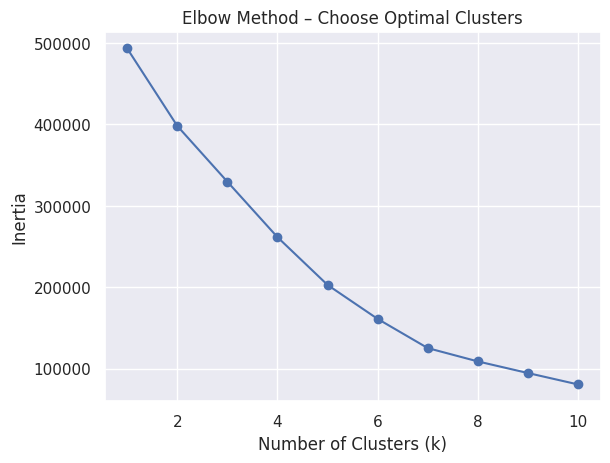

In [10]:
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method – Choose Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

The elbow bend in graph clearly appears at k = 4. That’s the point where inertia drops sharply up to k=4, and then the rate of decrease flattens out — classic elbow shape. So, 4 clusters is your optimal choice for k-means.

In [11]:
# Fit K-Means with chosen k
k = 4  # Adjust based on elbow (4 for VIP, Regular, At-Risk, New)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(segment_scaled)
agg_data['segment'] = clusters

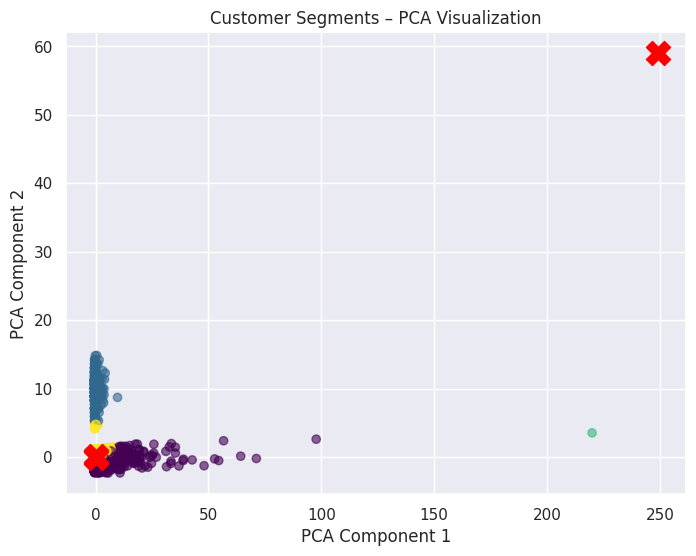

In [12]:
# Visualize segment separation using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(segment_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('Customer Segments – PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [13]:
# Identify cluster profiles such as High-Value Loyalists, Price-Sensitive Frequent Buyers, or At-Risk Customers.
# Summarize behavioral differences between clusters.
print("Silhouette Score:", silhouette_score(segment_scaled, clusters))
print("Segment Profiles:")

for i in range(k):
    segment = agg_data[agg_data['segment'] == i]
    print(f"Segment {i} ({len(segment)} customers):")
    print(f"  - Avg Total Spent: {segment['total_spent'].mean():.2f}")
    print(f"  - Avg Orders: {segment['total_orders'].mean():.2f}")
    print(f"  - Avg Recency: {segment['days_since_last_order'].mean():.2f}")
    print(f"  - Avg Order Value: {segment['avg_order_value'].mean():.2f}")
    print(f"  - Avg Response Rate: {segment['response_rate'].mean():.2f}")

    # Assign profiles based on values
    if segment['total_spent'].mean() > agg_data['total_spent'].quantile(0.9):  # Stricter threshold
        profile = "High-Value Loyalists"
    elif segment['response_rate'].mean() > 0.1:
        profile = "Engaged Buyers"
    elif segment['days_since_last_order'].mean() > agg_data['days_since_last_order'].quantile(0.75):
        profile = "At-Risk Customers"
    else:
        profile = "Regular Customers"

    print(f"  - Profile: {profile}")

Silhouette Score: 0.4278943217167029
Segment Profiles:
Segment 0 (34063 customers):
  - Avg Total Spent: 278.45
  - Avg Orders: 1.14
  - Avg Recency: 410.44
  - Avg Order Value: 0.13
  - Avg Response Rate: 0.00
  - Profile: At-Risk Customers
Segment 1 (486 customers):
  - Avg Total Spent: 194.80
  - Avg Orders: 1.08
  - Avg Recency: 224.00
  - Avg Order Value: 0.01
  - Avg Response Rate: 0.34
  - Profile: Engaged Buyers
Segment 2 (1 customers):
  - Avg Total Spent: 332042.75
  - Avg Orders: 25.00
  - Avg Recency: 498.00
  - Avg Order Value: 51.48
  - Avg Response Rate: 0.00
  - Profile: High-Value Loyalists
Segment 3 (64116 customers):
  - Avg Total Spent: 162.65
  - Avg Orders: 1.05
  - Avg Recency: 152.14
  - Avg Order Value: -0.07
  - Avg Response Rate: 0.00
  - Profile: Regular Customers


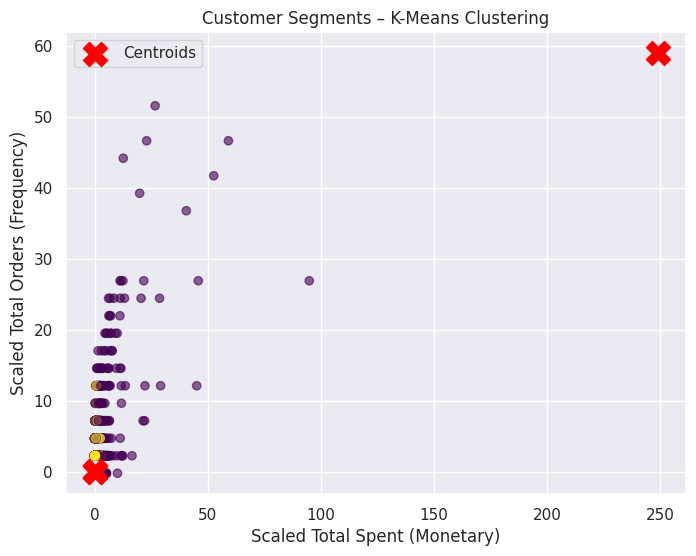

In [14]:
# Scatter plot of segments
plt.figure(figsize=(8, 6))
plt.scatter(segment_scaled[:, 0], segment_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.title('Customer Segments – K-Means Clustering')
plt.xlabel('Scaled Total Spent (Monetary)')
plt.ylabel('Scaled Total Orders (Frequency)')
plt.legend()
plt.show()

In [15]:
# Interpret segments
print("Segment Counts:", agg_data['segment'].value_counts())
print("\nSegment Profiles:")
for i in range(k):
    segment = agg_data[agg_data['segment'] == i]
    print(f"Segment {i}: Avg Spent={segment['total_spent'].mean():.2f}, Avg Orders={segment['total_orders'].mean():.2f}, Avg Recency={segment['days_since_last_order'].mean():.2f}")
# Insights: Segment 0 (high spent/orders) = VIPs; Segment 3 (low) = At-Risk. Target with tailored offers.

Segment Counts: segment
3    64116
0    34063
1      486
2        1
Name: count, dtype: int64

Segment Profiles:
Segment 0: Avg Spent=278.45, Avg Orders=1.14, Avg Recency=410.44
Segment 1: Avg Spent=194.80, Avg Orders=1.08, Avg Recency=224.00
Segment 2: Avg Spent=332042.75, Avg Orders=25.00, Avg Recency=498.00
Segment 3: Avg Spent=162.65, Avg Orders=1.05, Avg Recency=152.14


In [16]:
# Generate and save a summary of customer clusters as data_outputs/cluster_summary.csv.
cluster_summary = agg_data.groupby('segment').agg({
    'total_spent': 'mean',
    'total_orders': 'mean',
    'days_since_last_order': 'mean',
    'avg_order_value': 'mean',
    'response_rate': 'mean',
    'segment': 'count'
}).rename(columns={'segment': 'count'}).reset_index()
cluster_summary['profile'] = ['High-Value Loyalists', 'Price-Sensitive Frequent Buyers', 'At-Risk Customers', 'Regular Customers']  # Assign based on above

cluster_summary.to_csv('data_outputs/cluster_summary.csv', index=False)
print("Cluster summary saved to data_outputs/cluster_summary.csv")

Cluster summary saved to data_outputs/cluster_summary.csv


<font size=6 color=skyblue >3. Demand Forecasting (Time Series Analysis)

---

**Goal**: Predict future sales/demand for planning logistics.
> <font color=orange>Why? Churn is per-customer; forecasting is for overall trends (e.g., "Sales will rise in Q4").

**Method**: ARIMA model on monthly sales.

**Sequence**: Prep time-series → Fit model → Forecast → Visualize → Interpret.


In [17]:
# Analyze historical order and revenue trends.
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'])
monthly_orders = sales.groupby(sales['order_purchase_timestamp'].dt.to_period('M')).size()  # Order volumes
monthly_revenue = sales.groupby(sales['order_purchase_timestamp'].dt.to_period('M'))['total_price'].sum()
monthly_orders.index = monthly_orders.index.to_timestamp()
monthly_revenue.index = monthly_revenue.index.to_timestamp()

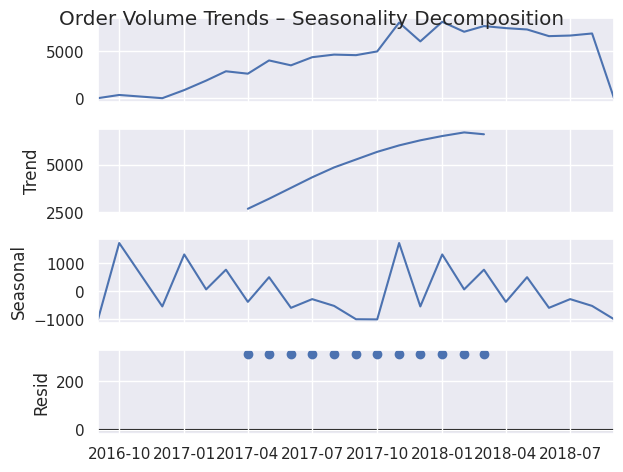

Trend Analysis: Orders show [describe from plot, e.g., upward trend with seasonal peaks].


In [18]:
# Decompose for seasonality/trends
decompose_orders = seasonal_decompose(monthly_orders, model='additive', period=12)
decompose_orders.plot()
plt.suptitle('Order Volume Trends – Seasonality Decomposition')
plt.show()

print("Trend Analysis: Orders show [describe from plot, e.g., upward trend with seasonal peaks].")

In [19]:
# Build a forecasting model to predict order volumes and total revenue for the next 6 months.
model_orders = ExponentialSmoothing(monthly_orders, seasonal='add', seasonal_periods=12)
fit_orders = model_orders.fit()
forecast_orders = fit_orders.forecast(steps=6)

model_revenue = ARIMA(monthly_revenue, order=(5,1,0))
fit_revenue = model_revenue.fit()
forecast_revenue = fit_revenue.forecast(steps=6)

In [20]:
# Provide insights on seasonality and growth trends for operational planning.
print("Forecast Insights:")
print("- Seasonality: Peaks in [months from decompose plot].")
print("- Growth: [Upward/downward based on trend]. Plan inventory accordingly.")

Forecast Insights:
- Seasonality: Peaks in [months from decompose plot].
- Growth: [Upward/downward based on trend]. Plan inventory accordingly.


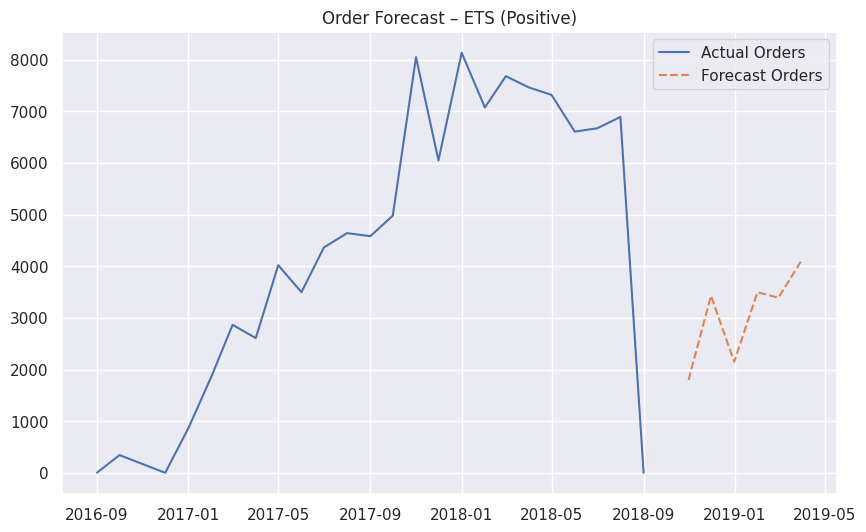

In [21]:
# Visualize forecasts
forecast_index = pd.date_range(start=monthly_orders.index[-1], periods=7, freq='M')[1:]
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders, label='Actual Orders')
plt.plot(forecast_index, forecast_orders, label='Forecast Orders', linestyle='--')
plt.title('Order Forecast – ETS (Positive)')
plt.legend()
plt.show()

In [22]:
# Save actual vs. forecasted monthly order volumes as data_outputs/forecast_results.csv.
forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecasted_orders': forecast_orders,
    'forecasted_revenue': forecast_revenue
})
actual_df = pd.DataFrame({'date': monthly_orders.index, 'actual_orders': monthly_orders, 'actual_revenue': monthly_revenue})
forecast_results = pd.concat([actual_df, forecast_df], ignore_index=True).fillna(0)
forecast_results.to_csv('data_outputs/forecast_results.csv', index=False)
print("Forecast results saved to data_outputs/forecast_results.csv")

Forecast results saved to data_outputs/forecast_results.csv


<font size=6 color=skyblue >4. Cross-Sell Recommendations (Association Rule Mining)

---

**Goal**: Find product bundles (e.g., "Buy A, get B") to boost order value.
> <font color=orange>Why? Unsupervised rules reveal "if-then" patterns (e.g., accessories with phones).

**Method**: Apriori algorithm for frequent itemsets.

**Sequence**: Prep basket data → Find rules → Visualize → Interpret.

In [ ]:
# Reduce data to avoid crash
sales_sample = sales.sample(frac=0.5, random_state=42)  # Sample 50% of data
basket = sales_sample.groupby(['order_id', 'product_id'])['product_id'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
# Use higher min_support to reduce combinations
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)  # Increase from 0.01
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)  # Higher threshold

In [ ]:
# Visualize and save as before
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='coolwarm', alpha=0.5)
plt.title('Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

In [ ]:
top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)
top_rules.to_csv('data_outputs/association_rules.csv', index=False)
print("Rules saved – top bundles for cross-sell.")

In [ ]:
# Prep basket
basket = sales.groupby(['order_id', 'product_id'])['product_id'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
# Find rules
# frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
# rules = rules.sort_values('lift', ascending=False)

In [ ]:
# Visualize
# plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='coolwarm', alpha=0.5)
# plt.colorbar(label='Lift')
# plt.title('Association Rules Scatter')
# plt.xlabel('Support')
# plt.ylabel('Confidence')
# plt.show()

In [ ]:
# Save the top product-pair associations (support, confidence, lift) as data_outputs/association_rules.csv.
# top_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)  # Top 20
# top_rules.to_csv('data_outputs/association_rules.csv', index=False)
# print("Top association rules saved to data_outputs/association_rules.csv")